    Dataset Collection

    Due to Zomato API Basic Plan restriction, we cannot collect enough data for analysis. To overcome this problem ‘Zomato.csv’ file is provided to analyse the data deeply and to get useful inference.
    Data has been collected from the Zomato API in the form of .json files(raw data) using the following url and stored in CSV file - 
https://developers.zomato.com/api/v2.1/search?entity_id=1&entity_type=city&start=1&count=20

    Details of zomato.csv


- Restaurant Id : Unique id of every restaurant across various cities of the world
- Restaurant Name : Name of the restaurant
- Country Code : Country in which restaurant is located
- City : City in which restaurant is located
- Address : Address of the restaurant
- Locality : Location in the city
- Locality Verbose : Detailed description of the locality
- Longitude : Longitude coordinate of the restaurant's location
- Latitude : Latitude coordinate of the restaurant's location
- Cuisines : Cuisines offered by the restaurant
- Average Cost for two : Cost for two people in different currencies
- Currency : Currency of the country
- Has Table booking : yes/no
- Has Online delivery : yes/ no
- Is delivering : yes/ no
- Switch to order menu : yes/no
- Price range : range of price of food
- Aggregate Rating : Average rating out of 5
- Rating color : depending upon the average rating color
- Rating text : text on the basis of rating of rating
- Votes : Number of ratings casted by people

In [1]:
# Importing libraries

import requests
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from heapq import nlargest 


`Considering only Indian restaurants in this analysis`

1. The dataset is highly skewed toward the cities included in Delhi-NCR. So, we will summarise all the other cities in Rest of India while those in New Delhi, Ghaziabad, Noida, Gurgaon, Faridabad to Delhi-NCR. Doing this would make our analysis turn toward Delhi-NCR v Rest of India.

***

##### 1.1 Plot the bar graph of number of restaurants present in Delhi NCR vs Rest of India.

In [2]:
file_obj = open('zomato.csv',errors = 'ignore')                 ##  opening the file
data = pd.read_csv(file_obj)                                    ## reading the file

In [3]:
data.head(3)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270


Delhi-NCR     : 7947 Restaurants
Rest of India : 705 Restaurants


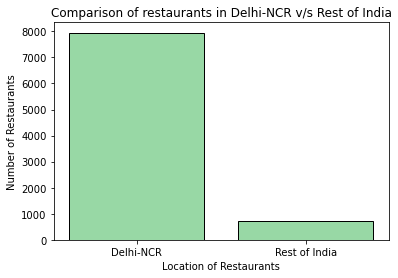

In [4]:
data.replace('New Delhi' ,'Delhi-NCR',inplace = True )          ## replacing all the city names of cities in delhi NCR 
data.replace('Gurgaon' ,'Delhi-NCR',inplace = True )            ## as Delhi NCR.
data.replace('Noida' ,'Delhi-NCR',inplace = True )
data.replace('Faridabad' ,'Delhi-NCR',inplace = True )
data.replace('Ghaziabad' ,'Delhi-NCR',inplace = True )

data = data[data['Country Code']==1]                          ## filtering out restaurants in india


rest = data [ data.City != 'Delhi-NCR']['Restaurant ID'].value_counts().sum()        ## saving restaurants in Rest of India 
in_delhi = data [ data.City == 'Delhi-NCR']['Restaurant ID'].value_counts().sum()    ## saving Restaurants in Delhi NCR

print('Delhi-NCR     : ' + str(in_delhi) + ' Restaurants')
print('Rest of India : ' + str(rest) + ' Restaurants')

plt.bar(['Delhi-NCR','Rest of India'],[in_delhi,rest],edgecolor="black",color=[0.2,0.7,0.3,0.5])   ## Data Visualisation

plt.xlabel('Location of Restaurants')
plt.ylabel('Number of Restaurants')
plt.title('Comparison of restaurants in Delhi-NCR v/s Rest of India')

plt.show()



##### 1.2 Find the cuisines which are not present in restaurant of Delhi NCR but present in rest of India.Check using Zomato API whether this cuisines are actually not served in restaurants of Delhi-NCR or just it due to incomplete dataset.

In [5]:
delhi = data[data.City=='Delhi-NCR']           ## getting restaurants in Delhi NCR


c_delhi = {}                                       
for i in delhi.Cuisines:                           ## making a dictionary of all the cuisines in Delhi NCR
    for j in i.split(','):
        key = j.strip()
        c_delhi[key]= c_delhi.get(key,0)+1
        

        
rest = data[data.City!='Delhi-NCR']                ## getting restaurants in Rest Of India
not_delhi = {}

for i in rest.Cuisines:                            ## making a dictionary for all cuisines which are not present in Delhi NCR
    for j in i.split(','):
        key = j.strip()
        if key not in c_delhi:
            not_delhi[key] = not_delhi.get(key,0)+1
            
print('Cuisines Not Present in Delhi-NCR')        ## printing the result
print('-----------------------------------')

for k in not_delhi:
    print(k)

    


Cuisines Not Present in Delhi-NCR
-----------------------------------
German
Malwani
BBQ
Cajun


In [4]:
## Cross-checking our above analysis through Zomato API to see whether these
## cuisines are actually not served in restaurants of Delhi-NCR or just it due to incomplete dataset.

In [6]:
## Call to get the city ID of Delhi NCR
header = {
    "user-key": "",  # enter your zomato-api key here
}

params = { 
    'q' : 'Delhi NCR'
}

r = requests.get('https://developers.zomato.com/api/v2.1/cities',headers = header, params = params)
c_id = r.json()['location_suggestions'][0]['id']
print('City ID of Delhi NCR:',c_id)


City ID of Delhi NCR: 1


In [7]:
## Checking whether the previously analyzed is present in Delhi NCR or not and printing if it's actually present in Delhi 

params = { 
    'city_id' : 1
}

r = requests.get('https://developers.zomato.com/api/v2.1/cuisines',headers = header, params = params)


print('Cuisines that ar not available in Delhi NCR according to given dataset but are Present in Delhi-NCR from API: ')
print('--------------------------------------------------------------------------------------------------------------')
for i in r.json()['cuisines']:
    if i['cuisine']['cuisine_name'] in not_delhi:
        print(i['cuisine']['cuisine_name'])

Cuisines that ar not available in Delhi NCR according to given dataset but are Present in Delhi-NCR from API: 
--------------------------------------------------------------------------------------------------------------
BBQ
Malwani


##### 1.3 Find the top 10 cuisines served by maximum number of restaurants in Delhi NCR and rest of India.

In [12]:
print('---------------------------')
print('TOP CUISINES OF DELHI-NCR')
print('---------------------------')

top_delhi_cui = nlargest(10,c_delhi,key=c_delhi.get)  ## using previously made dictionary to get most occuring cuisine in Delhi
for i in top_delhi_cui:
    print(i,' : ',c_delhi[i])


c_rest={}                    
for i in rest.Cuisines:                 ## making a dictionary containing cuisine name and frequency as value in Rest of India 
    for j in i.split(','):
        key = j.strip()
        c_rest[key]= c_rest.get(key,0)+1

print('------------------------------')
print('TOP CUISINES IN REST OF INDIA')
print('------------------------------')

top_rest_cui = nlargest(10,c_rest,key=c_rest.get)    ## getting the most frequently occuring cuisines
for i in top_rest_cui:
    print(i,' : ',c_rest.get(i))


---------------------------
TOP CUISINES OF DELHI-NCR
---------------------------
North Indian  :  3597
Chinese  :  2448
Fast Food  :  1866
Mughlai  :  933
Bakery  :  697
South Indian  :  569
Continental  :  547
Desserts  :  542
Street Food  :  538
Italian  :  535
------------------------------
TOP CUISINES IN REST OF INDIA
------------------------------
North Indian  :  349
Chinese  :  242
Continental  :  177
Italian  :  147
Cafe  :  136
Fast Food  :  97
South Indian  :  62
Mughlai  :  59
Desserts  :  55
Mexican  :  50


##### 1.4 Write a short detailed analysis of how cuisine served is different from Delhi NCR to Rest of India. Plot the suitable graph to explain your inference.

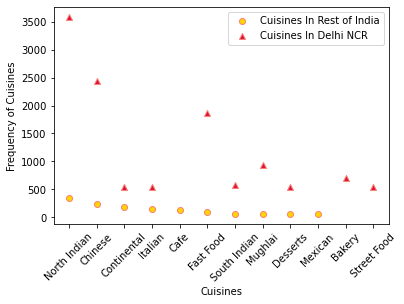

In [23]:
d= {}
for i in top_rest_cui:        ## getting the frequency of top cuisines in rest of India
    d[i]=c_rest.get(i)

## plotting the extracted frequencies
plt.scatter(d.keys(),d.values(),color="gold",label = "Cuisines In Rest of India",edgecolor = 'salmon')
plt.xticks(rotation=45)

d= {}
for i in top_delhi_cui:     ## getting the frequencies of top cuisines in Delhi
    d[i]=c_delhi.get(i)

## plotting the extracted frequencies
plt.scatter(d.keys(),d.values(),color="crimson",marker='^',label = "Cuisines In Delhi NCR", edgecolor = 'salmon')
plt.xticks(rotation=45)
plt.xlabel('Cuisines')
plt.ylabel('Frequency of Cuisines')
plt.legend()
plt.show()

2. User Rating of a restaurant plays a crucial role in selecting a restaurant or ordering the food from the restaurant.

##### 2.1 Write a short detail analysis of how the rating is affected by restaurant due following features: 

In [24]:
file_obj = open('zomato.csv',errors = 'ignore')         ## reading the data
data = pd.read_csv(file_obj)
data = data[data['Country Code']==1]                    ## filtering out restaurants not in india
data=data[data['Aggregate rating']!=0.0]                ## filtering out restaurants whose rating is not available

##### 2.1.1 Number of Votes given Restaurant

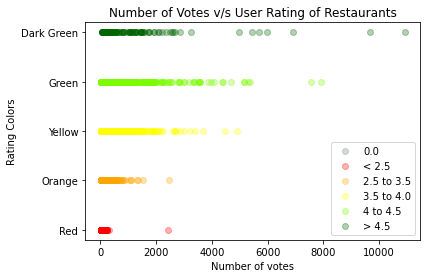

In [25]:
colors = ("red","white","orange","yellow","green","darkgreen")    ## Plotting votes against rating color

plt.scatter(data[data['Rating color']=='White']['Votes'],data[data['Rating color']=='White']['Rating color'],alpha=0.3,c = 'slategray',label = "0.0")
plt.scatter(data[data['Rating color']=='Red']['Votes'],data[data['Rating color']=='Red']['Rating color'],alpha=0.3,c = 'red',label = "< 2.5")
plt.scatter(data[data['Rating color']=='Orange']['Votes'],data[data['Rating color']=='Orange']['Rating color'],alpha=0.3,c = 'orange',label = "2.5 to 3.5")
plt.scatter(data[data['Rating color']=='Yellow']['Votes'],data[data['Rating color']=='Yellow']['Rating color'],alpha=0.3,c = 'yellow',label = "3.5 to 4.0")
plt.scatter(data[data['Rating color']=='Green']['Votes'],data[data['Rating color']=='Green']['Rating color'],alpha=0.3,c = 'lawngreen',label = "4 to 4.5")
plt.scatter(data[data['Rating color']=='Dark Green']['Votes'],data[data['Rating color']=='Dark Green']['Rating color'],alpha=0.3,c = 'darkgreen',label = "> 4.5")

plt.title('Number of Votes v/s User Rating of Restaurants')
plt.xlabel('Number of votes')
plt.ylabel('Rating Colors')
plt.legend()
plt.show()



##### 2.1.2  Restaurant serving more number of cuisines.

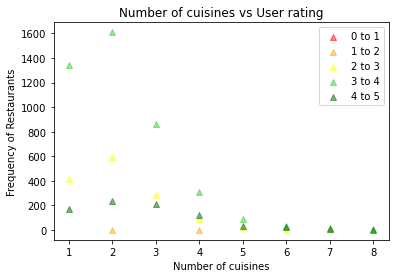

In [31]:


data['num_c']=data.Cuisines.str.split(',').str.len()                ## making a new features 'num_c' representing the number of cuisines present

## for collective analysis
colors = [ "red","orange","yellow","limegreen","darkgreen"]

## Visualizing data by going through each range of rating
for i in range(5):
    freq = data[(data['Aggregate rating']>=i) & (data['Aggregate rating']<i+1)].num_c.value_counts()
    plt.scatter(freq.index,freq.values,label = str(i)+" to " + str(i+1),alpha=0.5,marker='^',c = colors[i])

plt.legend()
plt.xlabel('Number of cuisines')
plt.ylabel('Frequency of Restaurants')
plt.title('Number of cuisines vs User rating')

plt.show()

##### 2.1.3   Average Cost of Restaurant

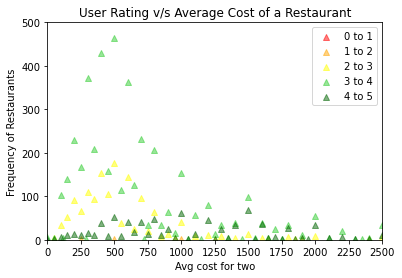

In [33]:
colors = [ "red","orange","yellow","limegreen","darkgreen"]

## plotting the Average cost for two for each range of rating
for i in range(5):
    freq = data[(data['Aggregate rating']>=i) & (data['Aggregate rating']<i+1)]['Average Cost for two'].value_counts()
    plt.scatter(freq.index,freq.values,label = str(i)+" to " + str(i+1),alpha=0.5,marker='^',c = colors[i])
    
plt.legend()

plt.xlabel('Avg cost for two')
plt.ylabel('Frequency of Restaurants')

plt.xticks([i for i in range(0,2501,250)])
plt.axis([0,2500,0,500])

plt.title('User Rating v/s Average Cost of a Restaurant')

plt.show()


##### 2.1.4   Restaurant serving some specific cuisines.

In [35]:


cuisines = []       ## making a new list which would contain cuisine name and the rating corresponding the restaurant
                    ## serving it


for i in data['Restaurant ID']:
    if data.Cuisines[data['Restaurant ID']==i].values[0]!=0:
        for j in data.Cuisines[data['Restaurant ID']==i].str.split(',').values[0]:  
            cuisines.append([j.strip(),data[data['Restaurant ID']==i]['Aggregate rating'].values[0]])
cuisines = pd.DataFrame(cuisines,columns= ['c_name','rating'])    ## making a Data Frame out of the list 


d = {}              ## making a dict which would contain cuisine name and the mean rating it has received
for i in range(len(cuisines)):
    key = cuisines['c_name'][i]
    if key not in d:
        ## getting all instances of a cuisine & getting its mean rating from the created Data Frame
        d[key]=cuisines[cuisines['c_name']==key]['rating'].values.mean()  
        
dict = {'c_name':list(d.keys()),'mean': list(d.values())} 
mean = pd.DataFrame(dict)            ## making a Data Frame now of cuisines and their mean rating


dict = {'c_name': cuisines['c_name'].value_counts().index ,'Number of Instances':cuisines['c_name'].value_counts().values }
c = pd.DataFrame(dict)           ## makng a Data frame having cuisine name and its number of instances we have considered 

result = pd.merge(mean,c,on='c_name')   ## Merging both Data Frames 




In [36]:
## Now we can visualize the cuisine rating in 2 ways :
## First, we can take only those cuisines which are occuring the most number of times
## Second, we can take all the cuisines in consideration no matter their occurences

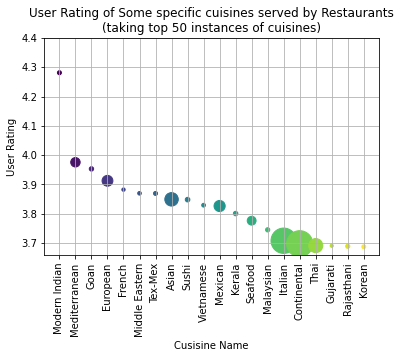

In [37]:

## First Approach
## Taking top 50 instances

r = result.nlargest(50,'Number of Instances').nlargest(20,'mean')   ## getting only the cuisines with most occurences
                                                                    ## and top 20 ratings

c = np.arange(20)   ## color array

 ## plotting cuisine name, its mean rating with instances as the bubble
plt.scatter(r['c_name'],r['mean'],s= r['Number of Instances'],c = c)  


plt.xticks(rotation = 90)
plt.grid()
plt.yticks([3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4])

plt.xlabel('Cusisine Name')
plt.ylabel('User Rating')
plt.title('User Rating of Some specific cuisines served by Restaurants\n(taking top 50 instances of cuisines)')

plt.show()

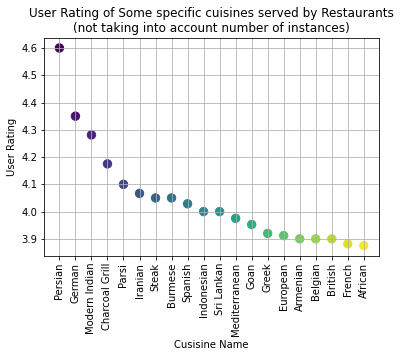

In [38]:
## Second Approach 
## Just taking highest rating 

c = np.arange(20)    ## color array

 ## plotting cuisine name, its mean rating 
plt.scatter(mean.nlargest(20,'mean')['c_name'],mean.nlargest(20,'mean')['mean'],c=c, s= 70)

plt.xticks(rotation = 90)
plt.xlabel('Cusisine Name')
plt.ylabel('User Rating')
plt.title('User Rating of Some specific cuisines served by Restaurants\n(not taking into account number of instances)')
plt.grid()

plt.show()

##### 2.2  Find the weighted restaurant rating of each locality and find out the top 10 localities with more weighted restaurant rating

`Weighted Restaurant Rating= Σ(number of votes * rating) / Σ(number of votes)`

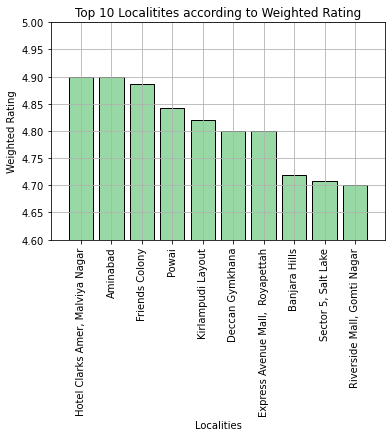

Hotel Clarks Amer, Malviya Nagar 4.9
Aminabad 4.9
Friends Colony 4.886916367367881
Powai 4.841868613138686
Kirlampudi Layout 4.820161290322581
Deccan Gymkhana 4.8
Express Avenue Mall,  Royapettah 4.8
Banjara Hills 4.7187617260787995
Sector 5, Salt Lake 4.707022552098202
Riverside Mall, Gomti Nagar 4.7


In [39]:
# Weighted Restaurant Rating=Σ (number of votes * rating) / Σ (number of votes)

w_rating = {}     # this dictionary contains Locality as key and its Weighted Rating as value

for i in data.Locality.value_counts().index:   ## looping through all unique Localities
    
    votes = np.array(data[data.Locality==i].Votes.values)    ## creating an array of all votes in the Locality
    rat = np.array(data[data.Locality==i]['Aggregate rating'].values)  ## creating an array of all rating in the Locality
    
    s = np.array(votes*rat)      ## getting the product of votes and rating array
    
    if votes.sum()!=0:         ## filtering out the instances where number of total votes is 0
        
        val = s.sum()/votes.sum()    ## val here contains value of Wighted Rating
        w_rating[i] = val            ## storing the weighted rating of the locality in dict
        


w_rat = pd.Series(w_rating)      ## creating Pandas Series 
dict = {'Locality': w_rat.index,'Weighted Rating': w_rat.values}
w_rating = pd.DataFrame(dict).nlargest(10,'Weighted Rating')   ## this dataframe contains top 10 Localities 

w_rating.reset_index(inplace = True,drop = True)              ##  resetting the index


## Plotting the bar Graph
plt.bar(w_rating['Locality'],w_rating['Weighted Rating'],edgecolor="black",color=[0.2,0.7,0.3,0.5])
plt.xticks(rotation = 90)
plt.xlabel('Localities')
plt.ylabel('Weighted Rating')
plt.axis([-1,10,4.6,5])
plt.grid()
plt.title('Top 10 Localitites according to Weighted Rating')
plt.show()

## Printing top 10 weighted Ratings
for i in range(len(w_rating)):
    print(w_rating['Locality'][i],w_rating['Weighted Rating'][i])   

3. Vizualization

##### 3.1 Top 15 restaurants have a maximum number of outlets

Domino's Pizza  :  74
Cafe Coffee Day  :  67
Subway  :  61
McDonald's  :  47
Green Chick Chop  :  44
Keventers  :  29
Pizza Hut  :  28
Barbeque Nation  :  25
Giani  :  24
Barista  :  21
Sagar Ratna  :  19
Dunkin' Donuts  :  19
Giani's  :  18
Pind Balluchi  :  18
Pizza Hut Delivery  :  18


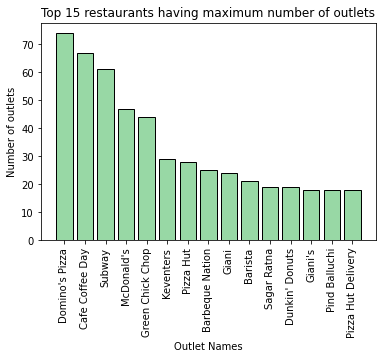

In [41]:
## looping through top 15 restaurants having most outlets and printing details
for i in range(len(data['Restaurant Name'].value_counts()[:15])): 
    print(data['Restaurant Name'].value_counts().index[i],' : ', data['Restaurant Name'].value_counts().values[i])

    
## plotting the bar graph of Outlets info of restaurants 
plt.bar(data['Restaurant Name'].value_counts().index[:15],data['Restaurant Name'].value_counts().values[:15],edgecolor="black",color=[0.2,0.7,0.3,0.5])

plt.xticks(rotation=90)
plt.xlabel('Outlet Names')
plt.ylabel('Number of outlets')
plt.title('Top 15 restaurants having maximum number of outlets')

plt.show()

##### 3.2 Histogram of aggregate rating of restaurant 

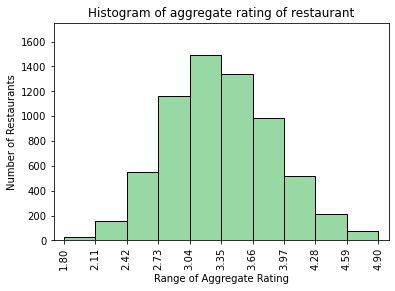

In [42]:
data = data[data['Aggregate rating']!=0]   ## dropping unrated restaurants


## plotting the histogram 
plt.hist(data['Aggregate rating'],edgecolor='black',bins = 10,color=[0.2,0.7,0.3,0.5])
plt.axis([1.7,5,0,1750])

xticks = np.histogram(data['Aggregate rating'],bins = 10)  ## getting the x-axis ranges using numpy.histogram to make 
                                                           ## the histogram evenly distributed

plt.xticks(xticks[1],rotation=90)
plt.xlabel('Range of Aggregate Rating')
plt.ylabel('Number of Restaurants')
plt.title('Histogram of aggregate rating of restaurant')

plt.show()

##### 3.3 Top 10 restaurants in the data with the highest number of votes.

Barbeque Nation  :  27835
AB's - Absolute Barbecues  :  13400
Toit  :  10934
Big Chill  :  10853
Truffles  :  9682
Farzi Cafe  :  9189
Chili's  :  8156
Hauz Khas Social  :  7931
Joey's Pizza  :  7807
Peter Cat  :  7574
Big Yellow Door  :  7511
Saravana Bhavan  :  7238
Pirates of Grill  :  7091
Karim's  :  6878
Domino's Pizza  :  6643
Subway  :  6124
Starbucks  :  6097
Dunkin' Donuts  :  5974
Big Brewsky  :  5705
Pind Balluchi  :  5582


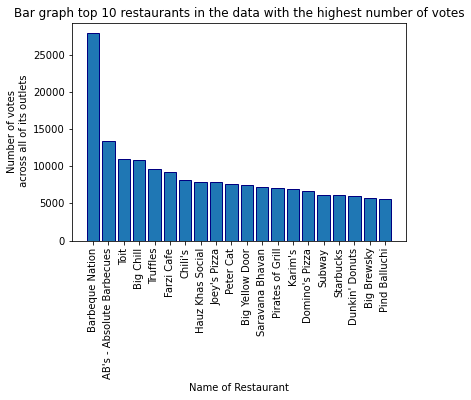

In [44]:
file_obj = open('zomato.csv',errors = 'ignore')
data = pd.read_csv(file_obj)
data = data[data['Country Code']==1]   ## considering only indian restaurants 

votes = {}  ## dict will contain Restaurant name as key and number of votes as value

## looping through all the restaurants 
## ( I have done so considering all same restaurant names as one i.e. considering all the outlets of one restaurant as one) 

for i in data['Restaurant Name'].value_counts().index:
    key = i
    if key not in votes:
        votes[key] = (data[data['Restaurant Name']==i]['Votes'].values.sum())  ## saving sum of votes of a restaurant
        
dict = {'name':list(votes.keys()),'votes':list(votes.values())}
votes = pd.DataFrame(dict)   ## creating a DataFrame 

for i in range(20):
    print(votes.nlargest(20,'votes')['name'].iloc[i],' : ',votes.nlargest(20,'votes')['votes'].iloc[i])
    
## Plotting the bar Graph
plt.bar(votes.nlargest(20,'votes')['name'],votes.nlargest(20,'votes')['votes'],edgecolor = 'navy')

plt.xticks(rotation = 90)

plt.xlabel('Name of Restaurant')
plt.ylabel('Number of votes\n across all of its outlets')
plt.title('Bar graph top 10 restaurants in the data with the highest number of votes')

plt.show()

##### 3.4 Top 10 cuisines present in restaurants in the USA

American     112
Seafood       59
Sandwich      49
Burger        49
Pizza         49
Steak         42
Italian       38
Breakfast     37
Mexican       36
Sushi         34
dtype: int64


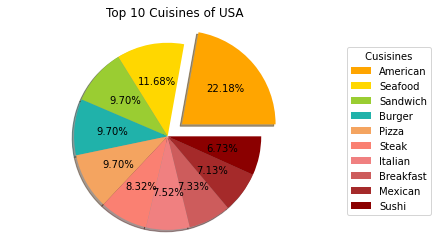

In [52]:

usa  = data[data['Country Code']==216].copy()  ## getting the data of USA

cuisines = []    ## creating a list of all cuisines present in USA
usa_cuisines = usa['Cuisines'].dropna()

for i in usa_cuisines:
    for j in i.split(','):
        cuisines.append(j.strip())
    
    
cuisines = pd.Series(cuisines)   # creating a Pandas  Series of cuisines in USA

## printing inf of top 10 most frequently occuring cuisines
print(cuisines.value_counts().nlargest(10)) 

largest = cuisines.value_counts().nlargest(10)  ## stroing those top cuisines


## Plotting the pie chart of distribution of cuisines
c = ['orange','gold','yellowgreen','lightseagreen','sandybrown','salmon','lightcoral','indianred','brown','darkred']


wedges,text,x = plt.pie(cuisines.value_counts().nlargest(10),shadow = True,explode = [0.2,0,0,0,0,0,0,0,0,0],autopct= "%.2f%%",colors = c)
plt.legend(wedges, cuisines.value_counts().nlargest(10).index,
          title=" Cusisines ",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.title('Top 10 Cuisines of USA')

plt.show()

##### 3.5 Bubble graph of Number of Restaurants present in the city of India and keeping the weighted restaurant rating of the city in a bubble

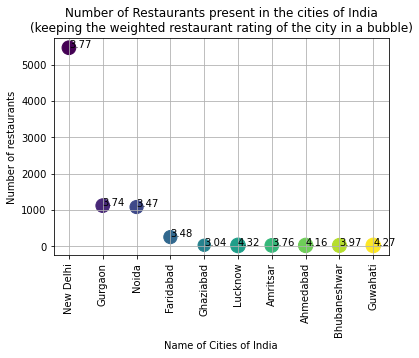

           Name  Number  W_Rating
0     New Delhi    5473  3.765872
1       Gurgaon    1118  3.743958
2         Noida    1080  3.472631
3     Faridabad     251  3.482979
4     Ghaziabad      25  3.037870
5       Lucknow      21  4.323527
6      Amritsar      21  3.764584
7     Ahmedabad      21  4.163215
8  Bhubaneshwar      21  3.967759
9      Guwahati      21  4.265733


In [53]:
file_obj = open('zomato.csv',errors = 'ignore')
data = pd.read_csv(file_obj)
ind = data[data['Country Code']==1].copy()  ## getting the data of restaurants in india


w_rating = []  ## this list will have city name, number of restaurants in city, its weighted rating

for i in ind['City'].value_counts().index:       ## looping htrough the Cities
    votes = np.array(ind[ind['City']==i].Votes.values)
    rat = np.array(ind[ind['City']==i]['Aggregate rating'].values)
    s = np.array(votes*rat)
     
    if votes.sum()!=0:
        val = s.sum()/votes.sum()    ## storing the weighted rating
        
        w_rating.append([i,ind[ind['City']==i]['City'].value_counts().values[0],val]) ## appending the wanted values
        
w_rating = pd.DataFrame(w_rating,columns = ['Name','Number','W_Rating'])  ## converting list to a Data Frame

c = np.arange(10) # color array

## plotting top 10 city name with most number of restaurants and bubble displaying their weighted rating
plt.scatter(w_rating.nlargest(10,'Number').Name,w_rating.nlargest(10,'Number').Number,s = w_rating.nlargest(10,'Number').W_Rating*50,marker = 'o',c=c)
plt.xticks(rotation = 90)

for i in w_rating.nlargest(10,'Number')['Name']: ## for displaying Weighted Rating
    plt.text(i,w_rating[w_rating['Name']==i]['Number'].values[0]+2,w_rating[w_rating['Name']==i]['W_Rating'].values[0].round(2),fontsize =10)

plt.xlabel('Name of Cities of India')
plt.ylabel('Number of restaurants')
plt.title('Number of Restaurants present in the cities of India\n(keeping the weighted restaurant rating of the city in a bubble)')
plt.grid()

plt.show()

print(w_rating[:10])
        